# Import packages & functions

In [12]:
import os
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import pickle
import string
import h5py
from tqdm import tqdm
import webdataset as wds
import gc
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from accelerate import Accelerator
from sklearn.linear_model import Ridge
# SDXL unCLIP requires code from https://github.com/Stability-AI/generative-models/tree/main
sys.path.append('generative_models/')
import sgm
from models import Clipper
from generative_models.sgm.modules.encoders.modules import FrozenOpenCLIPImageEmbedder # bigG embedder

# tf32 data type is faster than standard float32
torch.backends.cuda.matmul.allow_tf32 = True

# custom functions #
import utils

In [15]:
model_name = "subj01_40sess_hypatia_turbo_ridge"
subj=1
data_path = "../dataset"
imagery_voxels, all_images = utils.load_nsd_mental_imagery(subject=subj, mode="imagery", stimtype="all", snr=-1, average=True, nest=False)
vision_voxels, all_images = utils.load_nsd_mental_imagery(subject=subj, mode="vision", stimtype="all", snr=-1, average=True, nest=False)
_, _, shared1000_voxels, test_nsd_ids = utils.load_nsd(subject=subj, data_path=data_path)
clip_image_test = torch.load(f"{data_path}/preprocessed_data/subject{subj}/ViT-H-14_image_embeddings_test.pt")
clip_image_imagery = torch.load(f"{data_path}/preprocessed_data/subject{subj}/ViT-H-14_image_embeddings_nsdimagery.pt")
shared1000_cosine_sims = []
imagery_cosine_sims = []
vision_cosine_sims = []
for alpha in [0.01, 0.1, 1, 10, 100, 1000, 10000, 60000, 100000]:
    outdir = os.path.abspath(f'../train_logs/{model_name}_alpha_{alpha}')
    # Specify the directory where the weights are saved
    weights_dir = f'{outdir}/{float(alpha)}_alpha_weights.pkl'
    print(f"Loading Ridge with alpha={alpha}, dir: {weights_dir}")

    # Check if the weights file exists
    assert os.path.exists(weights_dir)
    # Load the regression weights
    with open(weights_dir, 'rb') as f:
        weights = pickle.load(f)

    # Create a new instance of the Ridge model
    model = Ridge(
        alpha=alpha,
        max_iter=50000,
        random_state=42,
    )

    # Set the regression weights in the model
    model.coef_ = weights["coef"]
    model.intercept_ = weights["intercept"]

    shared1000_pred_clip = model.predict(shared1000_voxels)

    cosine_sim = F.cosine_similarity(torch.from_numpy(shared1000_pred_clip), clip_image_test, dim=0)
    # print(f"Mean Shared1000 Cosine Similarity: {cosine_sim.mean().item()}")
    shared1000_cosine_sims.append(cosine_sim.mean().item())

    nsd_imagery_pred_clip = model.predict(imagery_voxels[:,0])

    cosine_sim = F.cosine_similarity(torch.from_numpy(nsd_imagery_pred_clip), clip_image_imagery, dim=0)
    # print(f"Mean Imagery Cosine Similarity: {cosine_sim.mean().item()}")
    imagery_cosine_sims.append(cosine_sim.mean().item())
    
    nsd_imagery_vision_pred_clip = model.predict(vision_voxels[:,0])

    cosine_sim = F.cosine_similarity(torch.from_numpy(nsd_imagery_vision_pred_clip), clip_image_imagery, dim=0)
    # print(f"Mean Vision Cosine Similarity: {cosine_sim.mean().item()}")
    vision_cosine_sims.append(cosine_sim.mean().item())
    

torch.Size([18, 1, 15724]) torch.Size([18, 3, 425, 425])
torch.Size([18, 1, 15724]) torch.Size([18, 3, 425, 425])
Loading Ridge with alpha=0.01, dir: /export/raid1/home/kneel027/MindEye_Imagery/train_logs/subj01_40sess_hypatia_turbo_ridge_alpha_0.01/0.01_alpha_weights.pkl
Loading Ridge with alpha=0.1, dir: /export/raid1/home/kneel027/MindEye_Imagery/train_logs/subj01_40sess_hypatia_turbo_ridge_alpha_0.1/0.1_alpha_weights.pkl
Loading Ridge with alpha=1, dir: /export/raid1/home/kneel027/MindEye_Imagery/train_logs/subj01_40sess_hypatia_turbo_ridge_alpha_1/1.0_alpha_weights.pkl
Loading Ridge with alpha=10, dir: /export/raid1/home/kneel027/MindEye_Imagery/train_logs/subj01_40sess_hypatia_turbo_ridge_alpha_10/10.0_alpha_weights.pkl
Loading Ridge with alpha=100, dir: /export/raid1/home/kneel027/MindEye_Imagery/train_logs/subj01_40sess_hypatia_turbo_ridge_alpha_100/100.0_alpha_weights.pkl
Loading Ridge with alpha=1000, dir: /export/raid1/home/kneel027/MindEye_Imagery/train_logs/subj01_40sess_h

In [16]:
print(f"Shared1000 Cosine Similarities: {shared1000_cosine_sims}")
print(f"Imagery Cosine Similarities: {imagery_cosine_sims}")
print(f"Vision Cosine Similarities: {vision_cosine_sims}")

Shared1000 Cosine Similarities: [0.3591850715954223, 0.3592037830184263, 0.3593903192365865, 0.36120048713, 0.37545220171395055, 0.42792712447083303, 0.4919355641554317, 0.5007764716582568, 0.4943952235743577]
Imagery Cosine Similarities: [0.08498773230357738, 0.0849939520440727, 0.08505595346463318, 0.08565707682511552, 0.09029209072124908, 0.10505483913609812, 0.12106818062664876, 0.12528371837698826, 0.12457502547857557]
Vision Cosine Similarities: [0.1235211139928714, 0.1235261590060039, 0.12357648220984097, 0.12406751625840329, 0.1280880906983275, 0.14419948842300587, 0.16103539111100543, 0.16091041355590724, 0.15871416025406848]


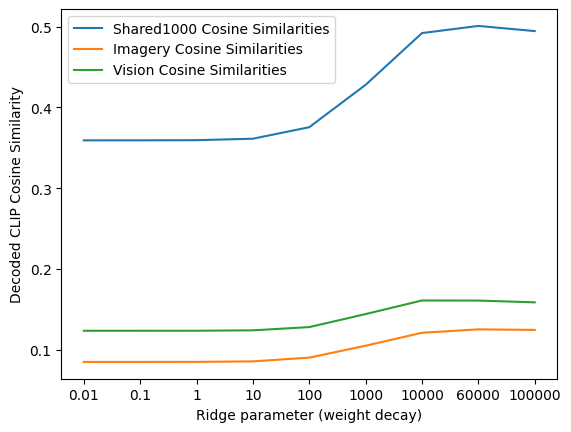

In [20]:
import matplotlib.pyplot as plt
x_tick_labels = [0.01, 0.1, 1, 10, 100, 1000, 10000, 60000, 100000]

plt.plot(range(9), shared1000_cosine_sims, label='Shared1000 Cosine Similarities')
plt.plot(range(9), imagery_cosine_sims, label='Imagery Cosine Similarities')
plt.plot(range(9), vision_cosine_sims, label='Vision Cosine Similarities')

plt.xlabel('Ridge parameter (weight decay)')
plt.ylabel('Decoded CLIP Cosine Similarity')
plt.xticks(range(9), [str(x) for x in x_tick_labels])
plt.legend()
plt.show()


Keyword arguments {'variation': 'fp16'} are not expected by StableUnCLIPImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/9 [00:00<?, ?it/s]

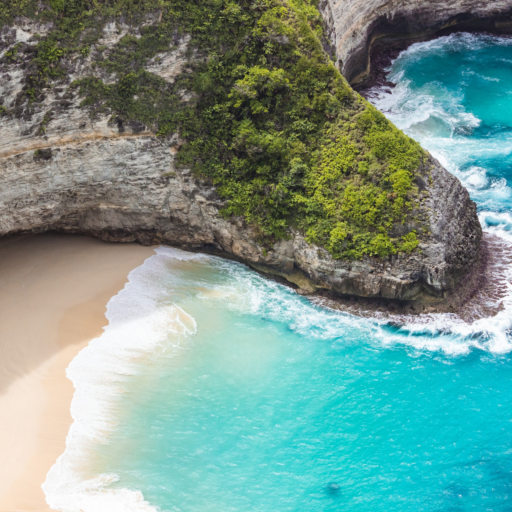

In [33]:
from diffusers import StableUnCLIPImg2ImgPipeline
from diffusers.utils import load_image
import torch

pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-1-unclip", torch_dtype=torch.float16, variation="fp16", cache_dir="../cache"
)
pipe = pipe.to("cuda")

url = "IP-Adapter/assets/images/river.png"
init_image = load_image(url)
init_image



  0%|          | 0/21 [00:00<?, ?it/s]

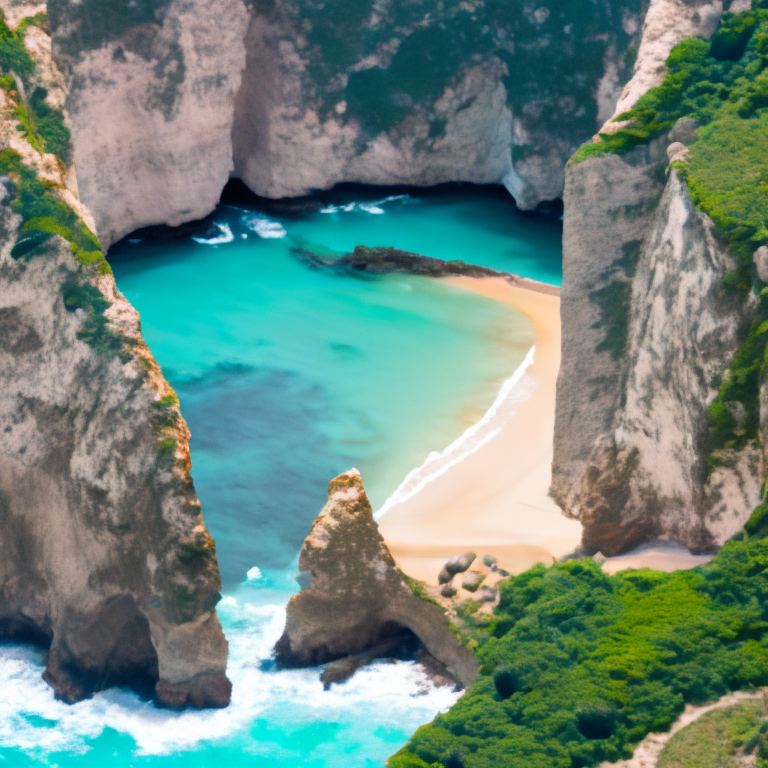

In [36]:
image = pipe(init_image).images[0]
image

  0%|          | 0/21 [00:00<?, ?it/s]

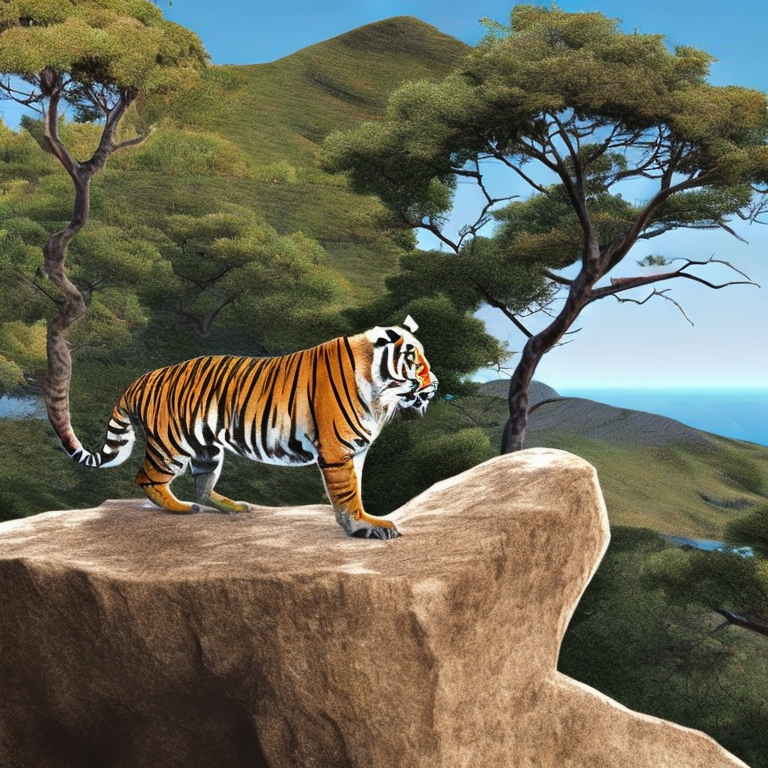

: 

In [54]:
prompt = "A tiger standing on the mountain photorealistic"

image = pipe(init_image, prompt=prompt, guidance_scale=10, noise_level=700).images[0]
image

In [ ]:
# Stack load_nsd
current_directory = os.getcwd()
subject = 1
beta_file = f"{current_directory}/data/preprocessed_data/subject01/whole_brain_include_heldout.pt"
#beta_file = "/home/naxos2-raid25/ojeda040/local/ojeda040/MindEye_Imagery/src/data/preprocessed_data/subject1/nsd_general_include_heldout.pt"
x = torch.load(beta_file).requires_grad_(False).to("cpu")
stim_descriptions = pd.read_csv("/".join(current_directory.split("/")[:-1]) + "/dataset/nsddata/experiments/nsd/nsd_stim_info_merged.csv", index_col=0)
subj_train = stim_descriptions[(stim_descriptions['subject{}'.format(subject)] != 0) & (stim_descriptions['shared1000'] == False)]
subj_test = stim_descriptions[(stim_descriptions['subject{}'.format(subject)] != 0) & (stim_descriptions['shared1000'] == True)]
test_trials = []
test_sessions = []
x_train = torch.zeros((9000, 3, x.shape[1])).to("cpu")
pbar = tqdm(desc="loading samples", total=x.shape[0])

# Collect the non-test data for the training set
for i in range(subj_train.shape[0]):
    for j in range(3):
        scanId = subj_train.iloc[i]['subject{}_rep{}'.format(subject, j)] - 1
        if(scanId < x.shape[0]):
            x_train[i, j, :] = x[scanId]
            pbar.update() 
            
            
x_train.shape
# betas = [voxels, reps, samples]
# torch.Size([9000, 3, 238508])

In [ ]:
# SNR Calulation
snr, signal, noise = calculate_snr(x_train)
print(f"SNR: {snr}")
print(f"SIGNAL: {signal}")
print(f"NOISE: {noise}")

In [ ]:
torch.min(snr)

In [ ]:
torch.max(snr)

In [ ]:
condition = snr > .35
snr_tensor = torch.where(condition, x, torch.tensor(0.0))
print(snr_tensor.shape)

snr_tensor_no_zeros = (snr_tensor != 0.0).any(dim=0)

# Filter out the zero columns
filtered_tensor = snr_tensor[:, snr_tensor_no_zeros]

print(filtered_tensor.shape)

In [ ]:
filtered_tensor.shape